# Handling Imbalanced Data in Machine Learning

當我們談到數據科學和分類建模時，一個常見且重要的挑戰是數據不平衡問題。這種問題在真實世界的資料集中經常出現，並且會對建模效果產生很大的影響。
讓我們用一個簡單的例子來說明這個問題。想像一下，我們是一家電信公司，正在嘗試通過簡訊推銷新產品。我們向數十萬名顧客發送了推銷簡訊，希望他們能夠回覆是否有興趣購買這個產品。然而，結果是絕大多數顧客根本沒有回覆，只有不到一千人表示有興趣。
這時，我們的資料集中會有非常不平衡的樣本：絕大多數都是“沒有回覆”或者“不感興趣”，而只有極少數是“有興趣”。這樣的數據不平衡會對我們的分類模型造成困擾，因為模型很容易被多數樣本所主導，結果變得不準確，無法正確識別少數樣本“有興趣”的情況。
當然，我們可以通過一些方法來改善這種情況。比如，使用集成學習方法（如隨機森林）或深度學習模型來提升分類效果。然而，這樣做也會帶來過擬合的風險，模型可能會對訓練數據過度學習，從而無法在新數據上表現良好。

# 以下介紹幾種常見處理資料不平衡的問題

## 1. Data-Level Methods
- **Oversampling**: Increase the number of samples in the minority class. Common techniques include Random Oversampling and Synthetic Minority Over-sampling Technique (SMOTE).
- **Undersampling**: Reduce the number of samples in the majority class. Techniques include Random Undersampling and NearMiss.
- **Data Augmentation**: Apply transformations (such as rotation, flipping, etc.) to the minority class samples to generate new samples.

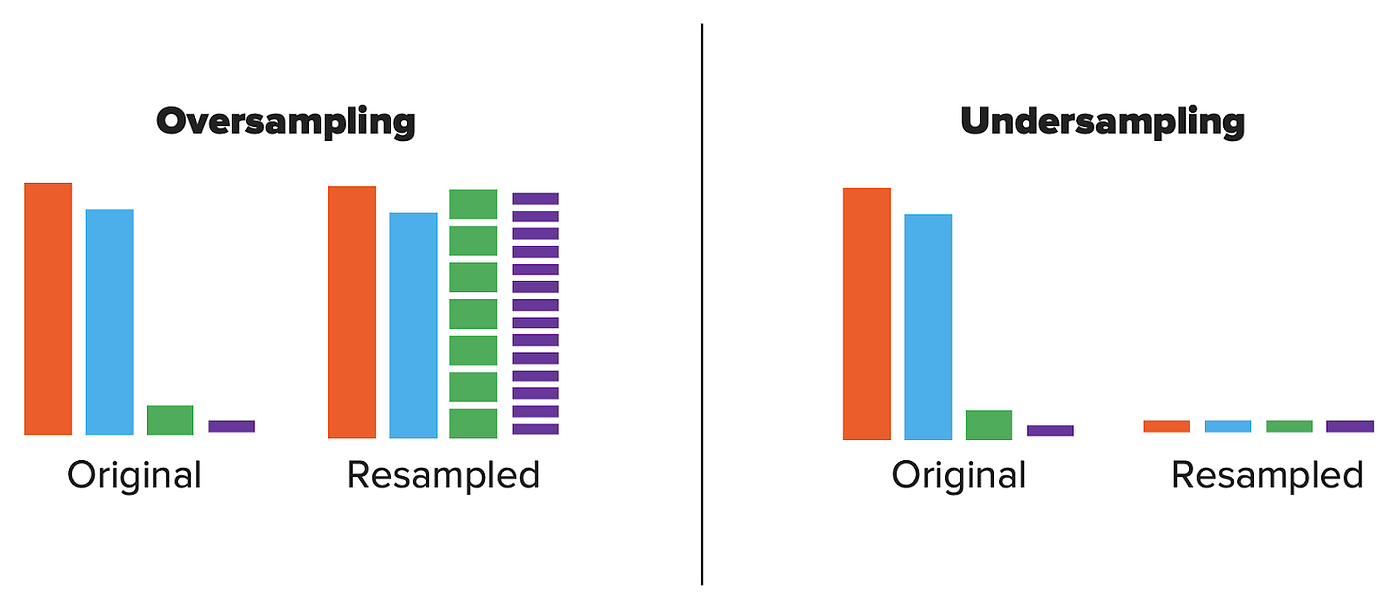
## 2. Algorithm-Level Methods
- **Class Weighting**: Assign higher weights to minority class samples during model training to make the model pay more attention to these samples. This method is commonly used in decision trees, random forests, and neural networks.
- **Improved Algorithms**: Use algorithms specifically designed to handle imbalanced data, such as Balanced Random Forest and Ensemble Methods.

## 3. Evaluation-Level Methods
- **Choose Appropriate Evaluation Metrics**: Accuracy often fails to reflect the true performance of a model on imbalanced datasets. Common evaluation metrics include Precision, Recall, F1 Score, Receiver Operating Characteristic Curve (ROC Curve), and Area Under Curve (AUC).

精確度 Precision 的公式為 TP / (TP + FP)，意思是所有被預測為正確的樣本中，有多少比例實際上是正確的。召回率的公式則是 TP / (TP + FN)，也就是說在實際上是正確的樣本中，有多少比例是被預測為正確的。
這兩個指標更加關注了實際上的正樣本，精確率隱含的意思是我們希望模型的預測結果更精確，召回率的意思則是希望正樣本能盡可能被偵測到。

# 不平衡數據集分類建模流程

對資料做一些處理：這邊思路有兩種，一種是將多數樣本中比較不具代表性的拿除掉，以免造成雜訊，稱為欠採樣，第二種是將少數樣本用某種方式重複抽樣或合成新樣本，稱為過採樣；本篇除了介紹這兩種方法以外，也會嘗試將這兩種方法結合，並配合一般建模流程提出完善的解決方案。

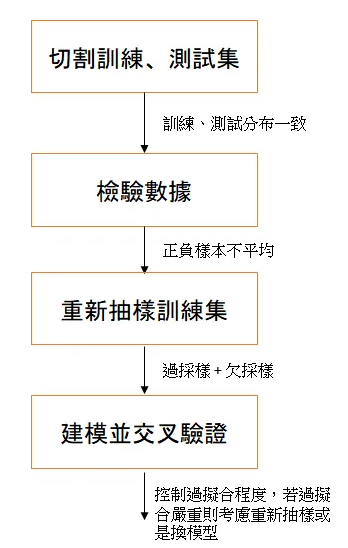


[ref](https://medium.com/%E6%95%B8%E5%AD%B8-%E4%BA%BA%E5%B7%A5%E6%99%BA%E6%85%A7%E8%88%87%E8%9F%92%E8%9B%87/smote-enn-%E8%A7%A3%E6%B1%BA%E6%95%B8%E6%93%9A%E4%B8%8D%E5%B9%B3%E8%A1%A1%E5%BB%BA%E6%A8%A1%E7%9A%84%E6%8E%A1%E6%A8%A3%E6%96%B9%E6%B3%95-cdb6324b711e)

## 範例資料 Credit Card Fraud Detection

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


In [10]:
df=pd.read_csv("./creditcard.csv")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [12]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Create Independent and dependent features

In [13]:
x=df.drop('Class',axis=1)
y=df['Class']

## Create the random state

In [26]:
normal=df[df['Class']==0]
fraud=df[df['Class']==1]

print('No of fraud records of data: {}'.format(fraud.shape[0]))
print('No of normal records of data: {}'.format(normal.shape[0]))

print("imbalance ratio: {} %".format(np.round((fraud.shape[0]*100/normal.shape[0]), 2)))


No of fraud records of data: 492
No of normal records of data: 284315
imbalance ratio: 0.17 %


From the above figure we can say that there are more no of values in normal(0) class and no values in 1 class,so we can clearly say that the dataset is imbalanced

## 欠採樣方法 : Edited Nearest Neighbor (ENN)
## downsampling

Imblearn is the library used for handling the imbalanced dataset which contains methods to handle upsampling,downsampling,etc.,

In [28]:
from imblearn.under_sampling import NearMiss

In [37]:
nm=NearMiss()
xsam,ysam=nm.fit_resample(x,y)

x_fraud = xsam[ysam==1]
x_normal = xsam[ysam==0]

y_fraud=ysam[ysam==1]
y_normal=ysam[ysam==0]

print('No of fraud records of data: {}'.format(x_fraud.shape[0]))
print('No of normal records of data: {}'.format(x_normal.shape[0]))



No of fraud records of data: 492
No of normal records of data: 492


Now we can able to see that the fraud and normal no of records are balanced

In [34]:
from collections import Counter

print('Shape of original dataset {}'.format(Counter(y)))
print('Shape of resampled dataset {}'.format(Counter(ysam)))

Shape of original dataset Counter({0: 284315, 1: 492})
Shape of resampled dataset Counter({0: 492, 1: 492})


## 過採樣方法 : Synthesized Minority Oversampling Technique (SMOTE)
## Oversampling: 
Oversampling makes the class with less number of data to balance with the other class by increasing the no of records,so that the dataset will be balanced.Oversampling is better than downsampling because it gives more no of data whereas in downsampling we lose some amount of data.

In [41]:
from imblearn.over_sampling import RandomOverSampler

In [48]:
ros=RandomOverSampler()
xosam,yosam=ros.fit_resample(x,y)

x_fraud = xosam[yosam==1]
x_normal = xosam[yosam==0]

y_fraud=yosam[yosam==1]
y_normal=yosam[yosam==0]

print('No of fraud records of data: {}'.format(x_fraud.shape[0]))
print('No of normal records of data: {}'.format(x_normal.shape[0]))

No of fraud records of data: 284315
No of normal records of data: 284315


In [44]:
print('Shape of original dataset {}'.format(Counter(y)))
print('Shape of resampled dataset {}'.format(Counter(yosam)))

Shape of original dataset Counter({0: 284315, 1: 492})
Shape of resampled dataset Counter({0: 284315, 1: 284315})


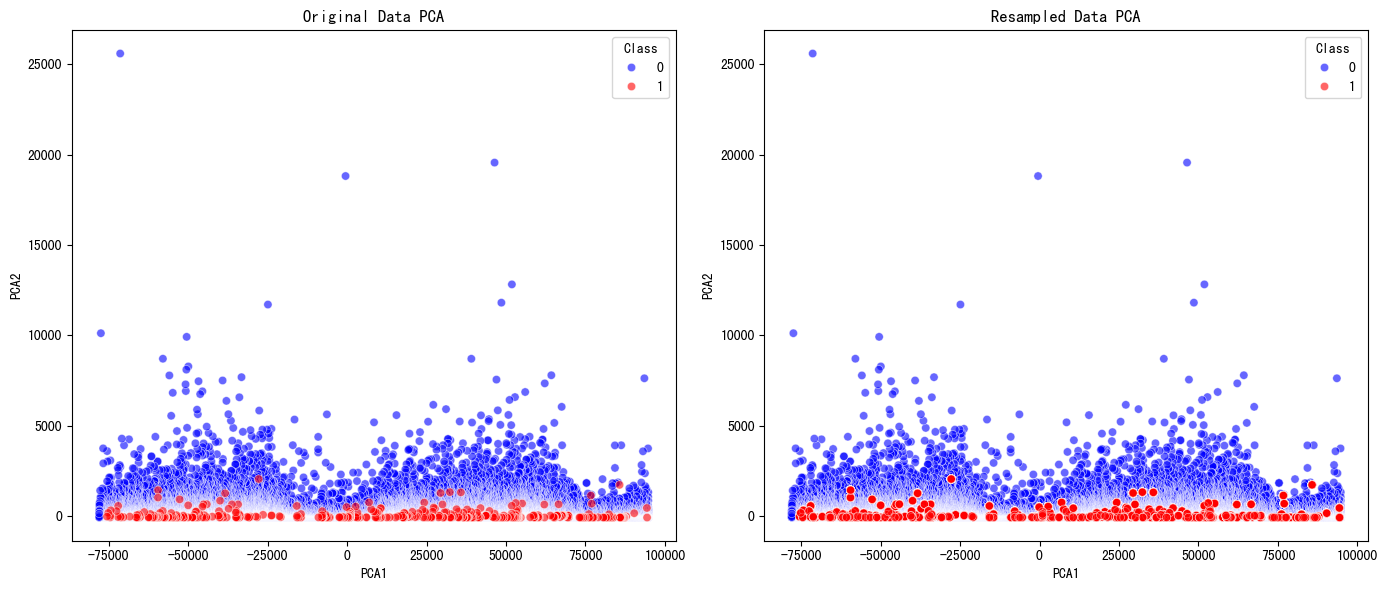

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.utils import resample
import seaborn as sns

# Set random seed for reproducibility
RANDOM_SEED = 42

# Load data
df = pd.read_csv("./creditcard.csv")

# Separate majority and minority classes
df_majority = df[df.Class == 0]
df_minority = df[df.Class == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=RANDOM_SEED) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Split data into features and target
x_upsampled = df_upsampled.drop('Class', axis=1)
y_upsampled = df_upsampled['Class']

# Apply PCA for visualization
pca = PCA(n_components=2, random_state=RANDOM_SEED)
x_pca = pca.fit_transform(df.drop('Class', axis=1))
x_upsampled_pca = pca.transform(x_upsampled)

# Create a DataFrame for visualization
df_pca = pd.DataFrame(data=x_pca, columns=['PCA1', 'PCA2'])
df_pca['Class'] = df['Class']

df_upsampled_pca = pd.DataFrame(data=x_upsampled_pca, columns=['PCA1', 'PCA2'])
df_upsampled_pca.reset_index(drop=True, inplace=True)  # Reset the index
y_upsampled.reset_index(drop=True, inplace=True)  # Reset the index
df_upsampled_pca['Class'] = y_upsampled

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Original data
# sns.scatterplot(ax=axes[0], data=df_pca, x='PCA1', y='PCA2', hue='Class', palette=['blue', 'red'], alpha=0.6)
# axes[0].set_title('Original Data PCA')

# Original data
sns.scatterplot(ax=axes[0], data=df_pca[df_pca['Class'] == 0], x='PCA1', y='PCA2', hue='Class', palette=['blue'], alpha=0.6)
sns.scatterplot(ax=axes[0], data=df_pca[df_pca['Class'] == 1], x='PCA1', y='PCA2', hue='Class', palette=['red'], alpha=0.6)
axes[0].set_title('Original Data PCA')

# Resampled data
sns.scatterplot(ax=axes[1], data=df_upsampled_pca[df_upsampled_pca['Class'] == 0], x='PCA1', y='PCA2', hue='Class', palette=['blue'], alpha=0.6)
sns.scatterplot(ax=axes[1], data=df_upsampled_pca[df_upsampled_pca['Class'] == 1], x='PCA1', y='PCA2', hue='Class', palette=['red'], alpha=0.6)
axes[1].set_title('Resampled Data PCA')

plt.tight_layout()
plt.show()




## Combination: Combination of Oversampling and Downsampling

In [52]:
from imblearn.combine import SMOTETomek

In [53]:
com=SMOTETomek(random_state=42)
xcom,ycom=com.fit_resample(x,y)

In [54]:
print('Shape of original dataset {}'.format(Counter(y)))
print('Shape of resampled dataset {}'.format(Counter(ycom)))

plt.figure(figsize=(7,7))
plt.tight_layout()
plt.subplot(2,2,1)
plt.title('Original Data')
sns.countplot(y)


plt.tight_layout()
plt.subplot(2,2,2)
plt.title('Downsampled data')
sns.countplot(ysam)

plt.tight_layout()
plt.subplot(2,2,3)
plt.title('Oversampled data')
sns.countplot(yosam)

plt.tight_layout()
plt.subplot(2,2,4)
plt.title('Smotet data')
sns.countplot(ycom)

plt.show()

Shape of original dataset Counter({0: 284315, 1: 492})
Shape of resampled dataset Counter({0: 283781, 1: 283781})


KeyboardInterrupt: 